In [1]:
# !pip install pytorch-metric-learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm, trange
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
import torchvision.transforms as transform
import pytorch_metric_learning as pml

In [2]:

train_ds = torchvision.datasets.LFWPeople(root="./data",split="train",download=True,
                                          transform=torchvision.transforms.ToTensor())
val_ds = torchvision.datasets.LFWPeople(root="./data",split="test",download=True,
                                        transform=torchvision.transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,original_data,classes_per_batch=30,samples_per_class=2):
        self.targets = np.array(original_data.targets)
        self.uniques = np.unique(self.targets)
        self.original_data = original_data
        self.classes_per_batch = classes_per_batch
        self.samples_per_class = samples_per_class
        ls=[]
        for i in np.unique(self.targets):
            ls.append(len(np.where(self.targets ==i)[0]))

        ls = np.array(ls)
        self.proper_classes = self.uniques[np.where(ls>=samples_per_class)[0]]
        
    def __len__(self):
        return np.sum([bool(np.sum(np.equal(i,self.proper_classes))) for i in self.targets])
    
    def __getitem__(self,idx):
        
        chosen_cls=np.random.choice(self.proper_classes,self.classes_per_batch,replace=False)
        chosen_samples = []
        for cls in chosen_cls:
            i = np.where(self.targets == cls)[0]
            j=np.random.choice(i,self.samples_per_class)
            chosen_samples.append(j)
        chosen_samples=np.concatenate(chosen_samples)
#         paths = [self.original_data.data[i] for i in chosen_samples]
        X = torch.zeros([len(chosen_samples),3,250,250])
        for i,path in enumerate(chosen_samples):
            img = self.original_data[path][0]
            X[i] = img
        return X,torch.tensor(self.targets[chosen_samples])


In [4]:
train_set = dataset(train_ds)
val_set = dataset(val_ds)

In [5]:
model = torchvision.models.resnet18(pretrained=True)

model.fc = nn.Linear(512,128)
model = model.to("cuda:0")

In [6]:
loss_fn = pml.losses.CircleLoss().to("cuda:0")
optimizer = torch.optim.SGD(model.parameters(),1e-4)
# batch_size = 16
# train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
# val_loader = DataLoader(val_set,batch_size=batch_size,shuffle=False)
miner_ = pml.miners.BatchEasyHardMiner()
epochs = 10
train_loss = []
val_loss = []


In [7]:


loop = trange(6000,leave = False)
loop.set_description("training")

for i in loop:
    model.train()
    X,y=train_set[0]
    optimizer.zero_grad()
    X = X.to("cuda:0")
    out = torch.nn.functional.normalize(model(X))
    y = y.to("cuda:0")
    idx = miner_(out,y)
    loss = loss_fn(out,y,idx)
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    model.eval()

    with torch.no_grad():
        X,y = val_set[1]
        X = X.to("cuda:0")
        out = torch.nn.functional.normalize(model(X))
        y = y.to("cuda:0")
        loss = loss_fn(out,y)


        val_loss.append(loss.item())
    loop.set_postfix(dict(train = train_loss[-1],val = val_loss[-1]))


  0%|          | 0/6000 [00:00<?, ?it/s]

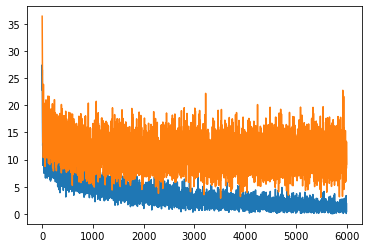

In [8]:
plt.plot(train_loss,label = "train")
plt.plot(val_loss, label="validation")

In [9]:
def smoothen(X,window):
    return np.convolve(X,np.ones(window))/window

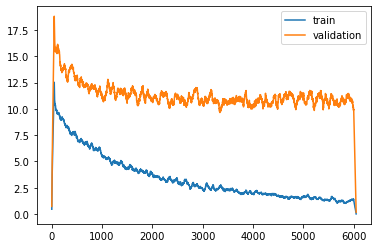

In [10]:
plt.plot(smoothen(train_loss,50),label = "train")
plt.plot(smoothen(val_loss,50), label="validation")
plt.legend()

In [11]:
test_set = dataset(val_ds,classes_per_batch=10,samples_per_class=5)
train_test_set = dataset(train_ds,classes_per_batch=10,samples_per_class=5)

In [16]:
with torch.no_grad():
    X,y = test_set[1]
    X = X.to("cuda:0")
    out = torch.nn.functional.normalize(model(X))
    y = y.to("cuda:0")
    loss = loss_fn(out,y)
    
    out = out.cpu()
    ou = out.numpy()
    y = y.cpu()
    y = y.numpy()
    print(f"test batch loss ={loss.item()}")

test batch loss =28.1138858795166


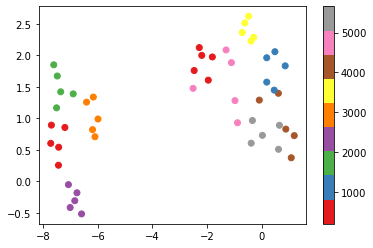

In [20]:
from umap import UMAP
umap=UMAP()
projections=umap.fit_transform(out)
plt.scatter(projections[:,0],projections[:,1],c = y,cmap = "Set1")
plt.colorbar()

In [23]:
with torch.no_grad():
    X,y = train_test_set[1]
    X = X.to("cuda:0")
    out = torch.nn.functional.normalize(model(X))
    y = y.to("cuda:0")
    loss = loss_fn(out,y)
    
    out = out.cpu()
    ou = out.numpy()
    y = y.cpu()
    y = y.numpy()
    print(f"train batch loss ={loss.item()}")

train batch loss =13.620939254760742


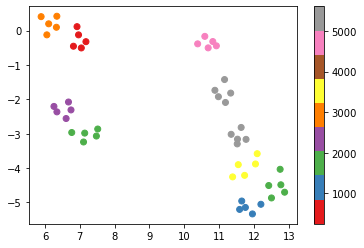

In [24]:
umap=UMAP()
projections=umap.fit_transform(out)
plt.scatter(projections[:,0],projections[:,1],c = y,cmap = "Set1")
plt.colorbar()

0.4
0.5
0.6
0.7
0.8
0.9
